 # TME5 sur T-SNE

### Definition de la classe t-sne

#### La fonction fit transforme est la fonction qui va permette de renvoyer une version de faible dimension des données passées en paramètre

In [6]:
%matplotlib inline
import numpy as np
import sklearn.metrics.pairwise as pairwise
from scipy import stats

class t_SNE():
    def __init__(self,perp,nb_iter,eps, momentum):
        self.perp=perp
        self.nb_iter=nb_iter
        self.eps=eps
        self.momentum=momentum
    """
    SNE : On veut minimiser la différence entre qj|i et pj|i (q est la meme que p sans le sigma et avec des y)
    """
    
    #Pj|i
    def Pjsi(self,sigma):
        distances = pairwise.euclidean_distances(self.X, squared = True)
        res = np.exp(-distances / (2. * (sigma**2)))
        res = res/np.sum(res-np.eye(len(self.X)),1).reshape(len(self.X),1) 
        return res
        
    def Qij(self):
        distances = pairwise.euclidean_distances(self.Y, squared = True)
        res = 1.0 / (1 + distances)
        res = res / res.sum()
        return res

    #Entropie de Shannon
    def H(self,sigma):
        pjsi = self.Pjsi(sigma)
        res = pjsi * np.log2(pjsi)
        return -1*np.sum(res,axis=1)    

    #fonction de coût : perplexity à determiner entre 5 et 50
    def perplexity(self,sigma):
        return np.power(2,self.H(sigma))
    
    def find_sigma(self, max_sigma, min_sigma, tolerence):
        nb_iter = 0
        while(nb_iter <= 100):
            nb_iter+=1
            sigma = (max_sigma+min_sigma)/2.0
            score = np.mean(self.perplexity(sigma))
            if(np.abs(score-self.perp)<0.1): return sigma
            if(score<self.perp):
                min_sigma = (max_sigma+min_sigma)/2.0
            else:
                max_sigma = (max_sigma+min_sigma)/2.0
        return sigma


    def gradient(self,pij,qij):
        res = np.zeros((self.Y.shape[0], self.Y.shape[1]))
        for i in range(len(self.Y)):
            #import pdb
            #pdb.set_trace()
            p1 = pij[i]-qij[i]
            p1 = p1.reshape((len(p1),1))
            p2 = self.Y[i] - self.Y
            p3 = 1/(1+np.power(np.linalg.norm(self.Y[i] - self.Y, axis=1),2))
            p3 = p3.reshape((len(p3),1))
            tmp = np.sum(p1*p2*p3,axis=0)
            res[i]=tmp
        return 4*res

    
    def fit_transform(self,X):        
        #initialisation
        self.X=X
        n = len(self.X)
        self.Y = np.random.randn(n,2)*1e-4
        pairwise = np.array((n, n))
        print "calcul de sigma"
        self.sigma = self.find_sigma(50,0,self.perp)
        print "sigma = ", str(self.sigma)
        #self.sigma = 9
        pairwise = self.Pjsi(self.sigma)
        pij = (pairwise+pairwise.T)/(2.0*n)  
        print "descente de gradient"
        for t in xrange(self.nb_iter):
            qij=self.Qij() #affinities
            if(t%10==0):
                loss = stats.entropy(pij, qij, 2).mean()
                print t,loss
            self.Y = self.Y - self.eps*self.gradient(pij,qij)#*self.momentum*(self.Y-self.Y)
        return self.Y
    

### import pour sklearn et affichage des resultats

In [7]:
# We import sklearn.
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})


### Fonction d'affichage du resultat de la projection de t-sne

In [8]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

### Chargement des images

In [9]:
digits = load_digits()
images = digits['images']

X = np.vstack([digits.data[digits.target==i] for i in range(10)])
y = np.hstack([digits.target[digits.target==i] for i in range(10)])

### Apprentissage avec sklearn

In [10]:
digits_proj_sklearn = TSNE(random_state=20150101).fit_transform(X)

### Résultat avec sklearn

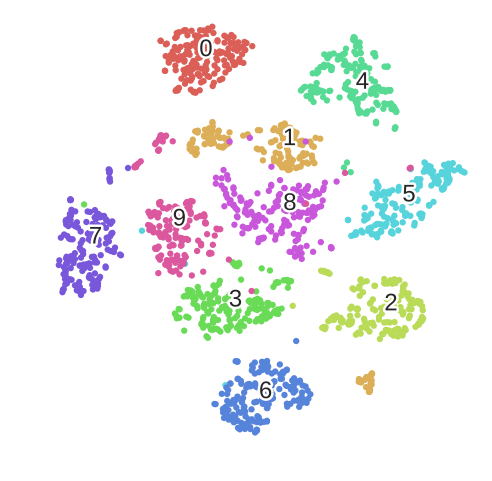

In [11]:
scatter(digits_proj_sklearn, y)
plt.show()

### Apprentissage avec notre fonction t_SNE

In [12]:
perp=30
nb_iter=200
eps=1e4
momentum=0
t_sne = t_SNE(perp,nb_iter,eps,momentum)
digits_proj_tme = t_sne.fit_transform(X)

calcul de sigma
sigma =  8.22143554688
descente de gradient
0 7.65044668678
10 3.81389183702
20 3.01574448085
30 2.66763981737
40 2.45779473651
50 2.25862423262
60 2.15344113647
70 2.06390289186
80 1.98641871993
90 1.96078380917
100 1.9045349035
110 1.83031532279
120 1.81030516815
130 1.78505305943
140 1.74787211153
150 1.71516768316
160 1.69515426318
170 1.6664989443
180 1.64377238008
190 1.62167609571


### Resultat avec notre fonction

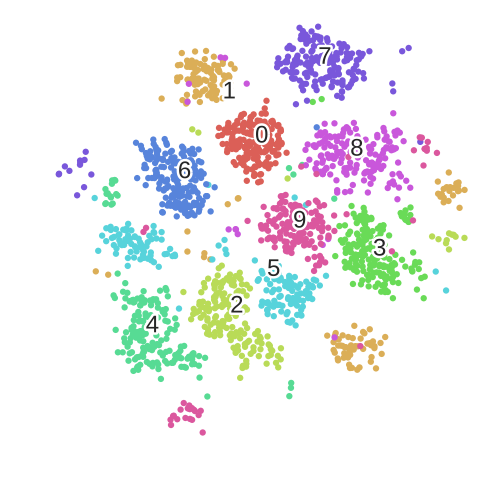

In [15]:
scatter(digits_proj_tme, y)
plt.show()


#Visualisation des utilisateurs et des films

On récupère les 2 matrices nbUser\*K et nbItems\*K avec K = 10

pour un modèle ayant eu comme performances :
score BIAS, train :  0.837292102241
score BIAS, test :  0.912765264516

###Visualisation des similarités entre utilisateurs

In [20]:
P = np.load('P_bias.npy')
digits_proj_sklearn = TSNE(random_state=20150101).fit_transform(P)

(-19.875783891491256,
 19.802291036763222,
 -20.182892862948989,
 20.536017656479569)

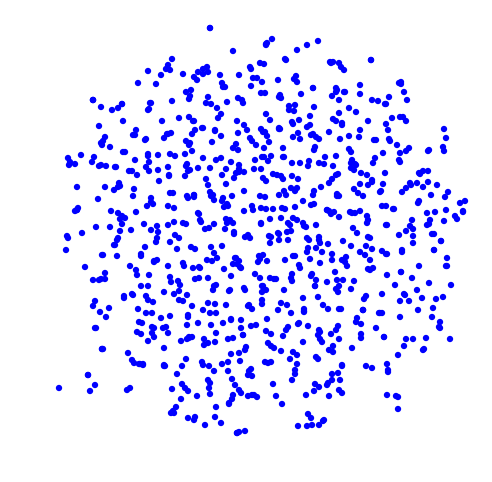

In [21]:
# We choose a color palette with seaborn.
palette = np.array(sns.color_palette("hls", 10))
x= digits_proj_sklearn
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40)
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')


###Visualisation des similarités entre films

In [24]:
Q = np.load('Q_bias.npy').T
digits_proj_sklearn = TSNE(random_state=20150101).fit_transform(Q)

(-15.716231119302824,
 15.990991355012611,
 -16.507041499536093,
 16.286843541006725)

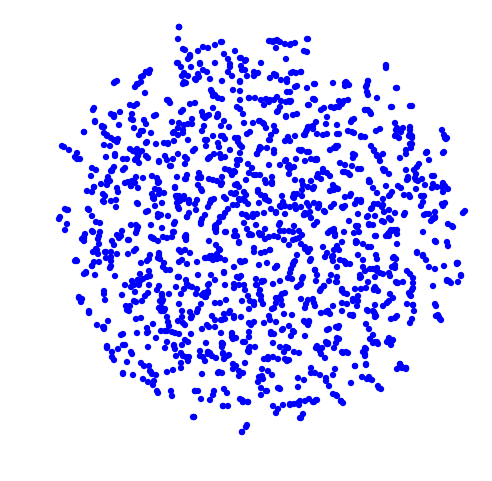

In [25]:
# We choose a color palette with seaborn.
palette = np.array(sns.color_palette("hls", 10))
x= digits_proj_sklearn
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40)
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')

#Conclusion

Il ne semble pas que des clusters distincts apparaissent avec t-SNE sur ces données.

Les communautés d'utilisateurs semblent tout de même plus distinctes mais aussi éparpillées et nombreuses.

Il faut garder à l'esprit que les matrices de départ ne recèlent pas forcément de structure (le score n'est pas excellent) et les données ne sont pas très nombreuses ou différentes : ce sont globalement des films populaires américains.

On pourrait tenter des analyses mais cela pourrait s'apparenter à de la torture de données, or notre conscience morale s'y refuse.